In [388]:
%matplotlib inline

import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

# Project Overview

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. <br>
In this project, we try to build a person of interest identifier based on financial and email data made public as a result of the Enron scandal. <br>
Persons of interest are identified as individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.

# Project Files 

- *final_project_dataset.pkl* : The dataset for the project
- *poi_id.py* : This file contains all the data analysis and POI identifier/classifier implementation
- *my_dataset.pkl*: 
- *my_classifier.pkl*:
- *my_feature_list.pk*:

In [389]:
## Data loading
#!/usr/bin/python
import matplotlib.pyplot as plt
import numpy as np
import sys
import pickle
import pandas as pd
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary'] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

# Data Exploration 

At the begining, let's start our investigation journey by expolring the input data set and knowing more about it.

<b>Important Characteristics:</b><br>

In [390]:
total_data_points_count = len(data_dict)
print "Total number of data points: ", total_data_points_count
print "Number of data points with undefined POI status: ", sum(1 for x in data_dict.values() if x['poi']=='NaN')
print "Total number of POIs: ", sum(1 for x in data_dict.values() if x['poi']==1)
print "Total number of non-POIs: ", sum(1 for x in data_dict.values() if x['poi']!=1)

Total number of data points:  146
Number of data points with undefined POI status:  0
Total number of POIs:  18
Total number of non-POIs:  128


<b>How many features do we have?and, which features will be used in building the POI identifier?</b>

In [391]:
print "- Total number of features in our data: ", len( data_dict[data_dict.keys()[0]].values())
print "- Features are: ",  data_dict[data_dict.keys()[0]].keys()

- Total number of features in our data:  21
- Features are:  ['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']


Our features belongs to two categories: financial features and email features. 

## Data Exploration
In this section, I will expolre all features and see how much they can be related to identifying POIs. How many of the them have missing values ?
The table below shows all features sorted ascendingly based in the count of missing values:
- "poi" has 0 missing values.
- 80% of data values for restricted_stock_deferred, restricted_stock_deferred, and director_fees are missing
- total_stock_value, total_payments, restricted_stock, salary, and expenses have the least percent of missing data values. They can be selected to be used in our POI classifier. 
Before selecting the features, let's see if there are outliers at any feature.

In [392]:
from texttable import Texttable
t = Texttable()
nan_list = []
# extract all features and find the Nan values count for each of them 
t.add_row(["Feature_Name","NaN_Values_Count","NaN_Values_Percent"])
for f in  data_dict[data_dict.keys()[0]].keys():
    feature_name = f
    feature_nan_values_count = sum(1 for x in data_dict.keys() if data_dict[x][f]=='NaN')
    feature_nan_values_percent = str(round((feature_nan_values_count/ float(total_data_points_count))*100,2))+"%"
    nan_list.append([feature_name,feature_nan_values_count,feature_nan_values_percent])

nan_list_sorted = sorted(nan_list,key=lambda l:l[1])
#print nan_list_sorted
# Sort features table ascending based on the count of missing values
for row in nan_list_sorted:
    t.add_row(row) #add each row to the table 
print t.draw()

+---------------------------+------------------+--------------------+
| Feature_Name              | NaN_Values_Count | NaN_Values_Percent |
+---------------------------+------------------+--------------------+
| poi                       | 0                | 0.0%               |
+---------------------------+------------------+--------------------+
| total_stock_value         | 20               | 13.7%              |
+---------------------------+------------------+--------------------+
| total_payments            | 21               | 14.38%             |
+---------------------------+------------------+--------------------+
| email_address             | 35               | 23.97%             |
+---------------------------+------------------+--------------------+
| restricted_stock          | 36               | 24.66%             |
+---------------------------+------------------+--------------------+
| exercised_stock_options   | 44               | 30.14%             |
+-------------------

## Data Outliers
Easiest way to detect outliers is visulaizing your data. I beleive that boxplot helps alot in showing outliers per each feature. But I was thinking it will be faster if I can represent all features by one scatter plot where I will 
be able to spot the extraneous values. I will use pca to transform all feature to only two features.
Note: As we know some features have a large amount of missing values. I'd prefere to replace all "NaN" values with 0 instead of considering them outliers and see the results.
The figures below show data points classes ( Red -> POI ,and Green -> Non-POI):
- Left-Figure: after applying PCA there are two clear outliers (one is POI and the other is non-POI). We can make a decision to delete them from the training set before knowing which data points they are.
- Right-Figure: all data points are annotated with the person name. Now, we can be sure which data points we need to delete. I will delete "Total" data point but I will not delete "LAY KENNETH L" data point as it is POI and I don't have much of POI points in the training set and I'm afraid deleting it may cause losing important info.

explained variance ratio (first two components): [ 0.97546601  0.02055258]


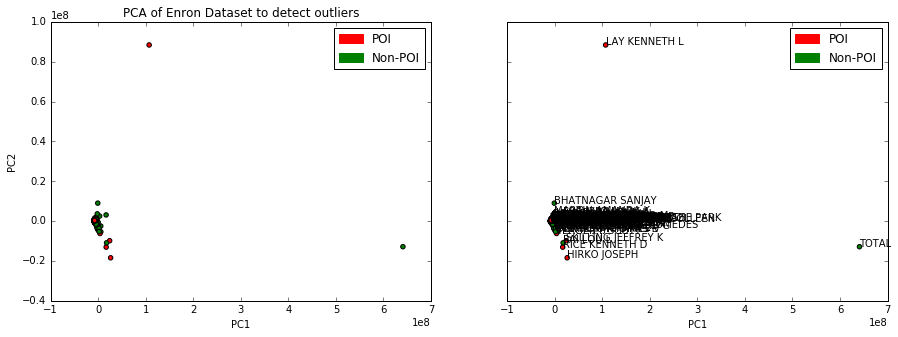

In [393]:
def apply_pca(data_dict_in):
    #print data_dict.values()
    person_names = []
    training_data = []

    for p in data_dict_in.keys():
        # replacing "NaN" wit Zero
        person_names.append(p)
        training_data.append([x if x!='NaN' else 0 for x in data_dict_in[p].values()])
    # I will remove email feature from the training set, as I think it doesn't have any thing to do with the pca
    training_data = np.array(training_data)
    training_data = np.delete(training_data, 19, axis=1)  # Delete emails 
    training_labels =  training_data[:,15]
    for i in range (0 , len(training_labels)):
        if training_labels[i]== 'True':
            training_labels[i] = 1.
        else:
            training_labels[i] = 0.

    #print type( training_labels)
    #print training_labels
    training_data = np.delete(training_data, 15, axis=1) # Delete POIs 
    #print training_data[:,15]
    # using PCA 
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    out_X_r = pca.fit_transform(training_data)
    # Percentage of variance explained for each components
    print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))
    # POIs colored in Red , while Non-POIs colored in green 
    c= ["r" if x == '1.0' else "g" for x in list(training_labels)]
    labels= ["POI" if x == '1.0' else "Non-POI" for x in list(training_labels)]

    return out_X_r, person_names, training_data, training_labels,c,labels 


X_r, person_names, training_data,training_labels,c,labels = apply_pca(data_dict)

# Ploting the PCA output
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5),sharey=True)
ax1.set_title("PCA of Enron Dataset to detect outliers")
ax1.scatter(X_r[:,0], X_r[:,1], c=c, label=labels)
#ax1.legend(labels)
ax1.set_ylabel("PC2")
ax1.set_xlabel("PC1")
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='POI')
green_patch = mpatches.Patch(color='green', label='Non-POI')
ax1.legend(handles=[red_patch,green_patch])

ax2.scatter(X_r[:,0], X_r[:,1], c=c, label=labels)
ax2.legend(handles=[red_patch,green_patch])
ax2.set_xlabel("PC1")

# Annaotating points to know the outliers names 

for i, txt in enumerate(person_names):
    ax2.annotate(txt, (X_r[i,0],X_r[i,1]))




explained variance ratio (first two components): [ 0.80541619  0.14738483]


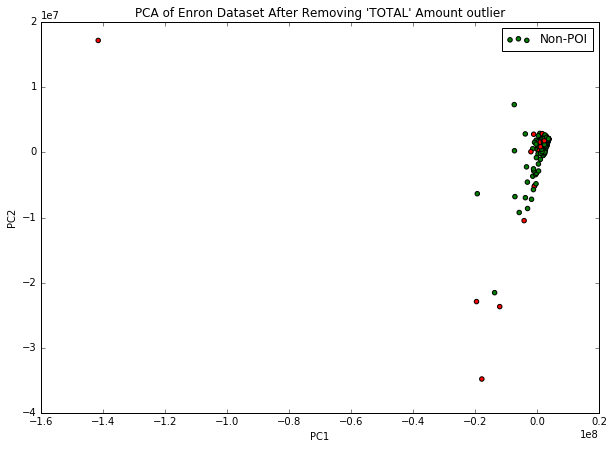

In [394]:
#Deleting Total outlier     
#del data_dict["TOTAL"]
outliers_keys = ["TOTAL"]
### Task 2: Remove outliers
for i in outliers_keys:
    for k in data_dict.keys():
        if k == i :
            del data_dict[i]
            
# Apply PCA again after removing outlier 
X_r, person_names, training_data,training_labels,c,labels = apply_pca(data_dict)

# Ploting the PCA output
f, ax1 = plt.subplots(1, 1, figsize=(10,7))
ax1.set_title("PCA of Enron Dataset After Removing 'TOTAL' Amount outlier")
ax1.scatter(X_r[:,0], X_r[:,1], c=c, label=labels)
ax1.legend(labels)
ax1.set_ylabel("PC2")
ax1.set_xlabel("PC1")
#for i, txt in enumerate(person_names):
#   ax1.annotate(txt, (X_r[i,0],X_r[i,1]))

## Feature Selection/Engineering
Selecting the best features that correlated to the output, means having better models performance. Selecting features with the most important info related to the target is the first step in building good models.</br>
I cannot decide which features will be used in my algorithm before expolring the relations between each one and the target(POI or Non-POI). I will use multiple features selection techniques to select the features: </br>
First: By <B>SelectKBest</B> features technique, You can see in the bar chart below: The cutoff is between the "Salary" feature and "deferred_income" feature. Based on feature scores, we can see the best features are the ones before the cutoff which are : </br>
- exercised_stock_options
- total_stock_value
- bonus 
- salary


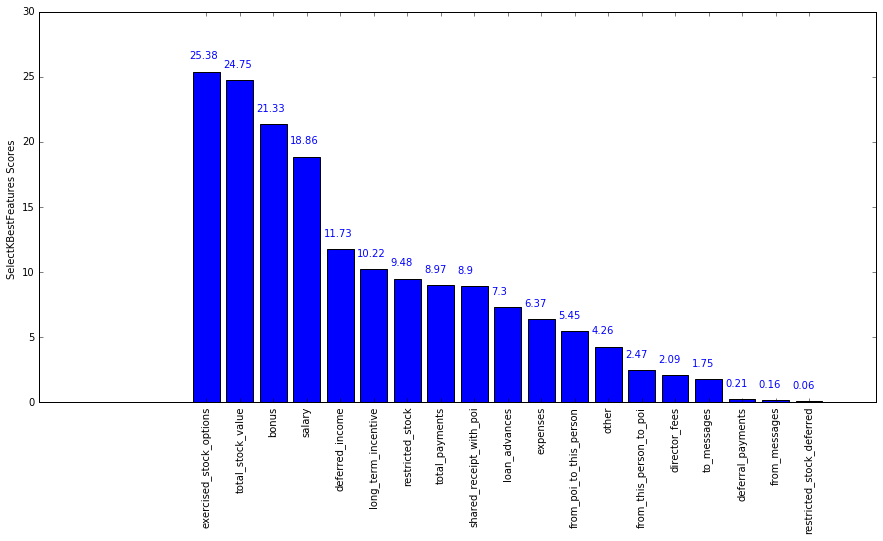

In [395]:
features_list = data_dict [data_dict.keys()[0]].keys()
#print "Removing email_address * POI from features list"
features_list.remove("poi")
features_list.remove("email_address")
#print "Current features list: ", features_list
#print "Selecting higest best 7 features"
##### Data PreProcessing
###creating dataFrame from dictionary - pandas
df = pd.DataFrame.from_dict(data_dict, orient='index', dtype=np.float)
df = df.replace("NaN",0.) # Replacing Nan Values 
training_labels = df.loc[:,'poi'].values
del df['poi']
del df['email_address']
features_list = list ( df.columns.values)
training_data = df.values
###########

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
X, y = training_data, training_labels
X_new = SelectKBest(f_classif)
selected_features =  X_new.fit_transform(X,y)
df_features_scores_p = pd.DataFrame({"Feature":features_list,"Score":X_new.scores_ , "P_value":X_new.pvalues_ })
df_features_scores_p = pd.DataFrame(df_features_scores_p[['Feature','Score','P_value']].sort_values(
        by=["Score"],ascending=False))
#print df_features_scores_p.to_string(index=False)
## Ploting featues scores 
fig, ax = plt.subplots( figsize=(15,7))   
x = np.arange(len( df_features_scores_p['Feature'].values))
y = df_features_scores_p['Score']
ax.bar( x ,y ,align='center')
plt.xticks(x,  df_features_scores_p['Feature'].values,rotation='vertical')
plt.ylabel('SelectKBestFeatures Scores ')
for i, v in enumerate(y):
    ax.text(i-0.5,v+1, str(np.round(v,2)), color='blue')
plt.show()

Second: By applying <B>Recursive Feature Elimination (RFE) </B> technique. It works by recursively removing attribute and build model based on the remaining attributes. Then,it uses the model accuracy to determine which attributes contribute the best to predicting the target. 
I will use RFE along with Logistic Regression to select the best 4 features, but first, the features data will be scaled just to make sure all features value have the same scale range from 0 to 1. RFE selects the following features:</br>

In [396]:
# Recursive Feature Elimination

# features Scaling 
from  sklearn.preprocessing import  MinMaxScaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(training_data)

from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression()
# create the RFE model and select 4 attributes
rfe = RFE(model, 4)
rfe = rfe.fit(features_scaled, training_labels)
#print training_data[0]
# summarize the selection of the attributes
rfe_selected_features_df = pd.DataFrame(columns=['feature_name', 'feature_ranking'])
rfe_selected_flage_list = rfe.support_
rfe_selected_features_ranking=rfe.ranking_

start_index =  1 ;
for i in range(0,len(rfe_selected_flage_list)):
    if rfe_selected_flage_list[i]:
        print "- ",features_list[i]
        #rfe_selected_features_df.append([features_list[i],rfe_selected_features_ranking[i]], 
         #                               columns=['feature_name', 'feature_ranking'])
        rfe_selected_features_df.loc[start_index]= [
            features_list[i],rfe_selected_features_ranking[i]]
        #print rfe_selected_features_df.loc[start_index]
        start_index = start_index + 1

#print rfe_selected_features_df.values

-  exercised_stock_options
-  bonus
-  total_stock_value
-  deferred_income


My final features list will inclued: 
- The common features that selected by RFE and SelectKBest features -> <b> exercised_stock_options, bonus, total_stock_value</b>
- <b>"deferred_income"</b> -> I beleive it is a good feature as you see in the graph below: POIs have average of  6.326916e+05 of deferred income which is greater the average for Non-POIs ( 1.299366e+05)

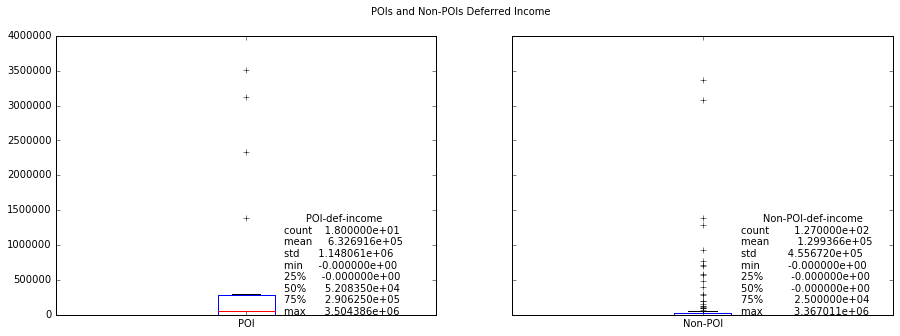

In [398]:

all_deferred_income = df.loc[:,'deferred_income'].values * -1
POIs_deferred_income = []
NON_POIS_deferred_income = []
for i  in range (0, len(training_labels)):

    if training_labels[i] == 1.:
        POIs_deferred_income.append(all_deferred_income[i] )
    else:
        NON_POIS_deferred_income.append(all_deferred_income[i])
        
     
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5),sharey=True)
ax1.boxplot(POIs_deferred_income, labels=["POI"])  
ax1.text(1.1,3,pd.DataFrame(POIs_deferred_income,columns=["POI-def-income"]).describe())
ax2.boxplot(NON_POIS_deferred_income, labels=["Non-POI"])
ax2.text(1.1,3,pd.DataFrame(
    NON_POIS_deferred_income,columns=["Non-POI-def-income"]).describe())
plt.suptitle ("POIs and Non-POIs Deferred Income")
plt.show()
 

#### Creating new features

I noticed that there is no feature that reflects the interaction between each person and POIs.So, I will calaculate and add the following new features:<br/>
1 - from_poi_to_this_person_perc = from_poi_to_this_person/to_messages => it shows how much this person received messages from POIs or interacted with them.<br/>
2 - from_this_person_to_poi_perc = from_this_person_to_poi/from_messages => it shows how much this person send messages to POIs or intereacted with them compared to his overall sent messages.<br/>

<b>The above 6 features will be used in finiding POIs.</b> Those features might not be the best selection that leads to best results. In the following section I will try them with different algorithms to see if they really help in finding POIs or not. 

#### Features Scaling
Having features within them scale range, helps machine learning algorithms to have better results. So, I will scale all features to be in range from 0 to 1. MinMaxScalar module from sklearn will be used to do the scaling.<br/>

In [404]:
### Task 3: Create new feature(s)
#####  calaculating the new features and add them to the data_dic

import math
for k, v in data_dict.iteritems():
    # adding from_poi_to_this_person_perc feature
    from_poi_to_this_person_perc = float(v['from_poi_to_this_person'])/float(v['to_messages'])
    ### Replacing nan values with zero
    if not math.isnan(from_poi_to_this_person_perc) :
        v['from_poi_to_this_person_perc']  = from_poi_to_this_person_perc
    else :
         v['from_poi_to_this_person_perc'] =0.

     # adding from_poi_to_this_person_perc feature
    from_this_person_to_poi_perc = float(v['from_this_person_to_poi'])/float(v['from_messages'])
     ### Replacing nan values with zero
    if not math.isnan (from_this_person_to_poi_perc ):
        v['from_this_person_to_poi_perc'] = from_this_person_to_poi_perc
    else:
         v['from_this_person_to_poi_perc'] = 0.
##### updating featuresList
##### using SelectKBest(f_classif, k=7)
##### =>  Highest 7 features are exercised_stock_options','total_stock_value','bonus','salary','deferred_income',
##### => 'long_term_incentive','restricted_stock'
#exercised_stock_options, bonus, total_stock_value
features_list = ['poi','exercised_stock_options','total_stock_value','bonus','deferred_income']
features_list_without =['poi','exercised_stock_options','total_stock_value','bonus','deferred_income']
##### Adding the new created features to the list
features_list.append('from_poi_to_this_person_perc')
features_list.append('from_this_person_to_poi_perc')### Task 3: Create new feature(s)


### Store to my_dataset for easy export below.
my_dataset = data_dict
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

data_without = featureFormat(my_dataset, features_list_without, sort_keys = True)
labels_without, features_without = targetFeatureSplit(data_without)


#### Scaling features in range from 0 to 1
from  sklearn.preprocessing import  MinMaxScaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
scaler2 = MinMaxScaler()
features_scaled_without = scaler2.fit_transform(features_without)


## Picking an algorithm for classification
In this section I tried different classifiers with different combination of parameters to find the best one that gives the best score.

*Parameter Tuning:*</br>
Each estimator has a set of parameters that have an impact on its performance. How Can you select the best values for those parameters? It is a tedious task to try all the parameters combinations manually to select the best one. Using GridSearch, I can get the parameters' values that gave the best score for the estimator. 


*Validation & Evaluation:* </br>

As a part of finding thr best classifier that works for your problem and its parameters values. you should define a scoring function which will be used as a comparator to select the best classifier. F1_score is used to compare between different classifiers. The higher F1_score you get means the better classifier you have. As I am doing parameter tuning for each classifier I use should validate and evaluate its performance. That can be done by splitting our data into Training dataset & Testing dataset. But if we did so, we might lose significant info in the training dataset because: we have unbalanced data (only 18 POIs out of 146 data points) and if we partitioned it, our model might be trained on Non-POIs only and as a result we will build a bad model. </br>
Cross validation is the best to use in validating our data, as it recursively divides the data randomly into training and testing sets (folds number), and calculate the average score for all folds. <b>Stratified shuffle split cross validation</b> will be used to pick the best classifier. </br>

F1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)

The table below shows the f-score for different classifiers and their tuned parameters:</br>
- SVM gave the lowest F1-score, while Logistics regression and GaussiaNB gave very close values for F1-score
- Logistic Regression Classifier gave lower F-Score in case of using Engineered features: </br>
        - With Engineered Features: F-Score -> 0.387
        - Without Engineered Features: F-Score -> 0.409
- Using Engineered Features doesn't make a big difference for F1-Score in case of GaussianNB.

###### The Final Model Description:

Based on the above results:

- <b>GaussianNB</b> will be selected as the final classifier for POIs identifier 
- The Engineered Features will be included in the final features list. 
- The final features list is : exercised_stock_options, total_stock_value, bonus, deferred_income from_poi_to_this_person_perc, from_this_person_to_poi_perc

*Final Evaluation Metric:*
By using stratified shuffle split cross validation to evaluate our POI identifier, calaculated the following:
- <b>Precesion</b> score is 0.48412. It is a low score that means our classifier, lower precision means that our algorithm returns less relevant results than irrelevant results. That means our algorithm has higher probability of identifying non-POIs as POIs (higher false positive rate) and that might have bad consequences.
- <b>Recall</b> score is 0.381. Lower recall score means higher false negative rate, means our algorithm might identify innocent people as POIs.
- Recall & Precision values are >0.3, but I believe they can be improved by having more useful engineered features.


In [423]:

### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
print "Selected Features: exercised_stock_options, total_stock_value, bonus, deferred_income" 
print 'Engineerd Features: from_poi_to_this_person_perc, from_this_person_to_poi_perc'
print ""

from sklearn import grid_search, linear_model
classifiers_stats_list = [] # this list includes the final classifiers results/scores
#With Engineered Features: is a flag to indincate if it is inculded or not (Yes: included, No:Not included )
classifiers_stats_list.append(['Classifier Name','With Engineered Features','Best Param','F1-Score'])

def gridSearchCLassifierParam(name, estimator, param):
    '''
    This function try different parameters combination with and without the Engineered Features
    and return the best combination in both cases
    '''
    clf = grid_search.GridSearchCV(estimator, param,cv=10,scoring='f1')
    clf.fit(features_scaled,labels)
    withEngFeaturesBestParam= clf.best_params_
    withEngFeaturesBestF1Score = clf.best_score_
    # Add to the classifiers result list
    classifiers_stats_list.append([name, 'Yes',str(withEngFeaturesBestParam),withEngFeaturesBestF1Score])
    clf.fit(features_scaled_without,labels_without)
    withoutEngFeaturesBestParam= clf.best_params_
    withoutEngFeaturesBestF1Score = clf.best_score_
    classifiers_stats_list.append([name, 'No',str(withoutEngFeaturesBestParam),withoutEngFeaturesBestF1Score])
    return 
##### First Try Logistic Regression 
param = { 'penalty':['l1','l2'],
         'C':[0.5, 1, 10,100,1000],'class_weight':['balanced'], 'max_iter':[100,200,500,700,1000], 
         'tol':[0.0001,0.00001]}
logreg = linear_model.LogisticRegression()
gridSearchCLassifierParam('Logistic Regression',logreg,param)
##### Second Classifier: SVM
from sklearn.svm import SVC
param = {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf','poly','sigmoid'],'class_weight':['balanced']}
svc_clf = SVC()
gridSearchCLassifierParam('SVC',svc_clf,param)
##### Third Classifier: Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()
param ={}
gridSearchCLassifierParam('GaussianNB',nb_clf,param)

#print classifiers_stats_list
#classifier_eval(logreg,features_scaled_without , labels,fold=100)
## Displaying the final results for classifers 
t = Texttable()
for row in classifiers_stats_list:
    t.add_row(row) #add each row to the table 
print t.draw()
clf = GaussianNB()
clf.fit(features_scaled,labels)

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.2, random_state=42)

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.
dump_classifier_and_data(clf, my_dataset, features_list)

Selected Features: exercised_stock_options, total_stock_value, bonus, deferred_income
Engineerd Features: from_poi_to_this_person_perc, from_this_person_to_poi_perc

+---------------------+---------------------+---------------------+----------+
| Classifier Name     | With Engineered     | Best Param          | F1-Score |
|                     | Features            |                     |          |
+---------------------+---------------------+---------------------+----------+
| Logistic Regression | Yes                 | {'penalty': 'l1',   | 0.387    |
|                     |                     | 'C': 10,            |          |
|                     |                     | 'max_iter': 100,    |          |
|                     |                     | 'tol': 0.0001,      |          |
|                     |                     | 'class_weight':     |          |
|                     |                     | 'balanced'}         |          |
+---------------------+---------------------

### Conclusion
Identifying POIs can be done using GaussianNB, with the features: exercised_stock_options, total_stock_value, bonus, deferred_income, from_poi_to_this_person_perc, from_this_person_to_poi_perc. I didn’t use PCA, as I believe we don’t need to do we have small number of features(only 5 features). This algorithm gave lower precision and recall that are less than 4.5, I think this performance can be improved by having more Engineered Features ( we can make use of the emails contents to find POIs).

# References 

- Hide Code When Sharing IPython Notebooks: http://protips.maxmasnick.com/hide-code-when-sharing-ipython-notebooks
- http://machinelearningmastery.com/how-to-identify-outliers-in-your-data/
- http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html
- http://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/
